<a href="https://colab.research.google.com/github/Gabendi/DL_HW/blob/master/VITMAV45_QBF10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# bit.ly/vitmav45-2019

In [5]:
import numpy as np
from sklearn import preprocessing
import copy
import matplotlib.pyplot as plt


In [6]:
def activation(x): # sigmoid
  return 1/(1+np.exp(-x))

def dactivation(x): # sigmoid derivalt
  return np.exp(-x)/((1+np.exp(-x))**2)

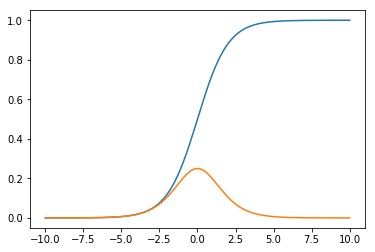

In [7]:
segedX = np.linspace(-10,10,200)
plt.plot(segedX,activation(segedX))
plt.plot(segedX,dactivation(segedX))

In [8]:
## nnetwork = MLP(2,3,1)
class MLP:
    def __init__(self, *args):
        np.random.seed(123)
        self.shape = args
        n = len(args)
        self.layers = []
        # bemeneti reteg, +1 a bias
        self.layers.append(np.ones(self.shape[0]+1))
        # tobbi reteg, bias nelkul
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                          self.layers[i+1].size)))
        # HF2 start momentum
        self.dw = []
        for i in range(n-1):
            self.dw.append(np.zeros((self.layers[i].size,
                                    self.layers[i+1].size))) #initializing the momentum part to 0 for the first run,
            #what we have to do is actually save the last correction matrices
        # HF2 end momentum
        self.reset()
    
    def reset(self):
        for i in range(len(self.weights)):
            Z = np.random.random((self.layers[i].size,
                                  self.layers[i+1].size))
            self.weights[i][...] = (2*Z-1) # -1..1-be atskalazzuk

    def propagate_forward(self, data):
        self.layers[0][0:-1] = data
        for i in range(1, len(self.shape)):
            self.layers[i][...] = activation(np.dot(self.layers[i-1],
                                                    self.weights[i-1]))
        return self.layers[-1]

    # backprop
    def propagate_backward(self, target, lrate=0.1, mrate=0.05,lambda0 = 0.0005): #HW CODE-> mrate-> multiplicator for momentum part
        deltas = []
        error = -(target-self.layers[-1]) # cost/loss/error funtion alapjan
        delta = np.multiply(error,
                            dactivation(np.dot(self.layers[-2],
                                               self.weights[-1]))) #f'(s(3))
        deltas.append(delta)
        

        
        # Gradiens kiszámítása a rejtett réteg(ek)ben
        for i in range(len(self.shape)-2,0,-1):
            delta = np.dot(deltas[0], self.weights[i].T)* \
                           dactivation(np.dot(self.layers[i-1],self.weights[i-1]))
            deltas.insert(0,delta)
            

        # Súlyok módosítása
        for i in range(len(self.weights)):
          layer = np.atleast_2d(self.layers[i])
          delta = np.atleast_2d(deltas[i])

          dwe = -lrate*np.dot(layer.T, delta) + mrate*self.dw[i] 
        
        
        # HF2 start l2reg
          #self.weights[i] += dwe - lrate * lambda0 * self.weights[i] L2 regularization 
        # HF2 end l2reg
        
         # HF2 start l1reg
          self.weights[i] += dwe - lrate * lambda0 * np.sign(self.weights[i]) #Lasso regularization
         # HF2 start l1reg
        
        # HF2 start momentum
          self.dw[i] = dwe #saving the correction matrix
        # HF2 end momentum     
        
        
        # Visszatérés a hibával
        return (error**2).sum()
		
def learn(network, X, Y, valid_split, test_split, epochs=5000, lrate=0.01, mrate=0.5,lambda0= 0.0001):#code

        # train-validation-test minták különválasztása
        X_train = X[0:int(X.shape[0]*(1-valid_split-test_split))]
        Y_train = Y[0:int(X.shape[0]*(1-valid_split-test_split))]
        X_valid = X[int(X.shape[0]*(1-valid_split-test_split)):int(X.shape[0]*(1-test_split))]
        Y_valid = Y[int(X.shape[0]*(1-valid_split-test_split)):int(X.shape[0]*(1-test_split))]
        X_test  = X[int(X.shape[0]*(1-test_split)):]
        Y_test  = Y[int(X.shape[0]*(1-test_split)):]
    
        # standardizálás
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test  = scaler.transform(X_test)

        # adatok osszekeverese
        randperm = np.random.permutation(len(X_train))
        X_train, Y_train = X_train[randperm], Y_train[randperm]
		
        # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
        for i in range(epochs):
          train_err = 0
          for k in range(X_train.shape[0]):
            network.propagate_forward( X_train [k] )
            train_err += network.propagate_backward( Y_train[k], lrate , mrate,lambda0)#code
          train_err /= X_train.shape[0]

          # validacio
          valid_err = 0
          o_valid = np.zeros(X_valid.shape[0])
          for k in range(X_valid.shape[0]):
            o_valid[k] = network.propagate_forward( X_valid[k] )
            valid_err += (o_valid[k] - Y_valid[k])**2
            
              
          valid_err /= Y_valid.shape[0]
          
            
          print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i,train_err,valid_err))

				
        # Tesztelési fázis
        test_err = 0
        o_test = np.zeros(X_test.shape[0])
        for k in range(X_test.shape[0]):
          o_test[k] = network.propagate_forward( X_test[k] )
          print("Predikcio:",o_test[k],"valos:",Y_test[k])
          test_err += (o_test[k] - Y_test[k])**2
        test_err /= Y_test.shape[0]  

        print("TESZT HIBA:",test_err)     


In [19]:
network = MLP(2,5,1)

In [20]:
#samples = np.zeros(4, dtype[('input',float,2), ('output',float,1)])
nb_samples = 200
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
  noise = np.random.normal(0,1,8)
  X[i],   Y[i]   = (-2+noise[0], -2+noise[1]), 0
  X[i+1], Y[i+1] = ( 2+noise[2], -2+noise[3]), 1
  X[i+2], Y[i+2] = (-2+noise[4],  2+noise[5]), 1
  X[i+3], Y[i+3] = ( 2+noise[6],  2+noise[7]), 0
  

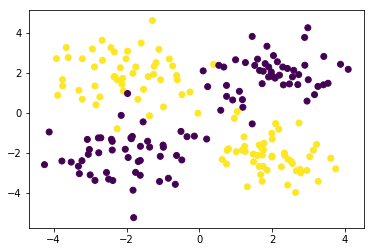

In [21]:
plt.scatter(X[:,0],X[:,1],c=Y[:])

In [22]:
network.reset() 
learn(network,X,Y,0.2,0.1,lrate=0.4,epochs=1000, mrate=0.5) #code

0 epoch, train_err: 0.2668, valid_err: 0.2693
1 epoch, train_err: 0.2630, valid_err: 0.2675
2 epoch, train_err: 0.2621, valid_err: 0.2662
3 epoch, train_err: 0.2613, valid_err: 0.2649
4 epoch, train_err: 0.2602, valid_err: 0.2632
5 epoch, train_err: 0.2583, valid_err: 0.2601
6 epoch, train_err: 0.2535, valid_err: 0.2524
7 epoch, train_err: 0.2400, valid_err: 0.2313
8 epoch, train_err: 0.2095, valid_err: 0.1929
9 epoch, train_err: 0.1687, valid_err: 0.1554
10 epoch, train_err: 0.1344, valid_err: 0.1305
11 epoch, train_err: 0.1116, valid_err: 0.1157
12 epoch, train_err: 0.0968, valid_err: 0.1064
13 epoch, train_err: 0.0869, valid_err: 0.1001
14 epoch, train_err: 0.0798, valid_err: 0.0956
15 epoch, train_err: 0.0746, valid_err: 0.0923
16 epoch, train_err: 0.0707, valid_err: 0.0898
17 epoch, train_err: 0.0677, valid_err: 0.0879
18 epoch, train_err: 0.0652, valid_err: 0.0863
19 epoch, train_err: 0.0633, valid_err: 0.0851
20 epoch, train_err: 0.0616, valid_err: 0.0840
21 epoch, train_err: 0.

181 epoch, train_err: 0.0262, valid_err: 0.0866
182 epoch, train_err: 0.0262, valid_err: 0.0867
183 epoch, train_err: 0.0262, valid_err: 0.0868
184 epoch, train_err: 0.0261, valid_err: 0.0869
185 epoch, train_err: 0.0261, valid_err: 0.0869
186 epoch, train_err: 0.0261, valid_err: 0.0870
187 epoch, train_err: 0.0261, valid_err: 0.0871
188 epoch, train_err: 0.0261, valid_err: 0.0871
189 epoch, train_err: 0.0260, valid_err: 0.0872
190 epoch, train_err: 0.0260, valid_err: 0.0873
191 epoch, train_err: 0.0260, valid_err: 0.0873
192 epoch, train_err: 0.0260, valid_err: 0.0874
193 epoch, train_err: 0.0259, valid_err: 0.0875
194 epoch, train_err: 0.0259, valid_err: 0.0875
195 epoch, train_err: 0.0259, valid_err: 0.0876
196 epoch, train_err: 0.0259, valid_err: 0.0876
197 epoch, train_err: 0.0259, valid_err: 0.0877
198 epoch, train_err: 0.0258, valid_err: 0.0878
199 epoch, train_err: 0.0258, valid_err: 0.0878
200 epoch, train_err: 0.0258, valid_err: 0.0879
201 epoch, train_err: 0.0258, valid_err:

362 epoch, train_err: 0.0239, valid_err: 0.0928
363 epoch, train_err: 0.0239, valid_err: 0.0928
364 epoch, train_err: 0.0239, valid_err: 0.0928
365 epoch, train_err: 0.0238, valid_err: 0.0928
366 epoch, train_err: 0.0238, valid_err: 0.0929
367 epoch, train_err: 0.0238, valid_err: 0.0929
368 epoch, train_err: 0.0238, valid_err: 0.0929
369 epoch, train_err: 0.0238, valid_err: 0.0929
370 epoch, train_err: 0.0238, valid_err: 0.0929
371 epoch, train_err: 0.0238, valid_err: 0.0929
372 epoch, train_err: 0.0238, valid_err: 0.0929
373 epoch, train_err: 0.0238, valid_err: 0.0930
374 epoch, train_err: 0.0238, valid_err: 0.0930
375 epoch, train_err: 0.0238, valid_err: 0.0930
376 epoch, train_err: 0.0238, valid_err: 0.0930
377 epoch, train_err: 0.0238, valid_err: 0.0930
378 epoch, train_err: 0.0238, valid_err: 0.0930
379 epoch, train_err: 0.0237, valid_err: 0.0930
380 epoch, train_err: 0.0237, valid_err: 0.0931
381 epoch, train_err: 0.0237, valid_err: 0.0931
382 epoch, train_err: 0.0237, valid_err:

533 epoch, train_err: 0.0227, valid_err: 0.0944
534 epoch, train_err: 0.0227, valid_err: 0.0944
535 epoch, train_err: 0.0227, valid_err: 0.0944
536 epoch, train_err: 0.0227, valid_err: 0.0944
537 epoch, train_err: 0.0227, valid_err: 0.0944
538 epoch, train_err: 0.0227, valid_err: 0.0944
539 epoch, train_err: 0.0227, valid_err: 0.0944
540 epoch, train_err: 0.0227, valid_err: 0.0944
541 epoch, train_err: 0.0227, valid_err: 0.0944
542 epoch, train_err: 0.0227, valid_err: 0.0944
543 epoch, train_err: 0.0227, valid_err: 0.0944
544 epoch, train_err: 0.0227, valid_err: 0.0944
545 epoch, train_err: 0.0226, valid_err: 0.0944
546 epoch, train_err: 0.0226, valid_err: 0.0944
547 epoch, train_err: 0.0226, valid_err: 0.0944
548 epoch, train_err: 0.0226, valid_err: 0.0944
549 epoch, train_err: 0.0226, valid_err: 0.0944
550 epoch, train_err: 0.0226, valid_err: 0.0944
551 epoch, train_err: 0.0226, valid_err: 0.0945
552 epoch, train_err: 0.0226, valid_err: 0.0945
553 epoch, train_err: 0.0226, valid_err:

715 epoch, train_err: 0.0215, valid_err: 0.0951
716 epoch, train_err: 0.0215, valid_err: 0.0951
717 epoch, train_err: 0.0215, valid_err: 0.0951
718 epoch, train_err: 0.0215, valid_err: 0.0951
719 epoch, train_err: 0.0215, valid_err: 0.0951
720 epoch, train_err: 0.0214, valid_err: 0.0951
721 epoch, train_err: 0.0214, valid_err: 0.0951
722 epoch, train_err: 0.0214, valid_err: 0.0951
723 epoch, train_err: 0.0214, valid_err: 0.0951
724 epoch, train_err: 0.0214, valid_err: 0.0951
725 epoch, train_err: 0.0214, valid_err: 0.0951
726 epoch, train_err: 0.0214, valid_err: 0.0951
727 epoch, train_err: 0.0214, valid_err: 0.0951
728 epoch, train_err: 0.0214, valid_err: 0.0951
729 epoch, train_err: 0.0214, valid_err: 0.0951
730 epoch, train_err: 0.0214, valid_err: 0.0952
731 epoch, train_err: 0.0214, valid_err: 0.0952
732 epoch, train_err: 0.0214, valid_err: 0.0952
733 epoch, train_err: 0.0213, valid_err: 0.0952
734 epoch, train_err: 0.0213, valid_err: 0.0952
735 epoch, train_err: 0.0213, valid_err:

896 epoch, train_err: 0.0200, valid_err: 0.0953
897 epoch, train_err: 0.0200, valid_err: 0.0953
898 epoch, train_err: 0.0199, valid_err: 0.0953
899 epoch, train_err: 0.0199, valid_err: 0.0953
900 epoch, train_err: 0.0199, valid_err: 0.0953
901 epoch, train_err: 0.0199, valid_err: 0.0953
902 epoch, train_err: 0.0199, valid_err: 0.0953
903 epoch, train_err: 0.0199, valid_err: 0.0953
904 epoch, train_err: 0.0199, valid_err: 0.0953
905 epoch, train_err: 0.0199, valid_err: 0.0953
906 epoch, train_err: 0.0199, valid_err: 0.0953
907 epoch, train_err: 0.0199, valid_err: 0.0953
908 epoch, train_err: 0.0199, valid_err: 0.0953
909 epoch, train_err: 0.0198, valid_err: 0.0953
910 epoch, train_err: 0.0198, valid_err: 0.0953
911 epoch, train_err: 0.0198, valid_err: 0.0953
912 epoch, train_err: 0.0198, valid_err: 0.0953
913 epoch, train_err: 0.0198, valid_err: 0.0953
914 epoch, train_err: 0.0198, valid_err: 0.0953
915 epoch, train_err: 0.0198, valid_err: 0.0953
916 epoch, train_err: 0.0198, valid_err: